In [1]:
import os

import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt

import torch
import torchvision

import torch.nn as nn

In [2]:
class VGG16_guided_backprop(nn.Module):
    def __init__(self):
        super(VGG16_guided_backprop, self).__init__()
        self.encoder = torchvision.models.vgg16(weights='DEFAULT').features
        
        self.relu_change_inplace()
        self.relu_set_hook()
    
    def relu_change_inplace(self):
        for module in self.encoder.children():
            if isinstance(module, nn.ReLU):
                module.inplace = False

    def relu_set_hook(self):
        def relu_backward_hook_function(module, grad_in, grad_out):
            modified_grad_out = torch.clamp(grad_in[0], min=0.)
            return (modified_grad_out, )

        for module in self.encoder.children():
            if isinstance(module, nn.ReLU):
                module.register_full_backward_hook(relu_backward_hook_function)
    
    def generate_gradients(self, x):
        # set requires_grad to get input gradient
        x = x.clone().detach().requires_grad_(True)
        feature = self.encoder(x)

        # get feature top-1 activation
        n, c, h, w = feature.shape
        feature = feature.reshape(n, -1)
        mask = (feature == feature.max(dim=-1, keepdim=True)[0])
        top1_activation = mask * feature

        feature = feature.reshape(n, c, h, w)
        top1_activation = top1_activation.reshape(n, c, h, w)

        # backward
        self.encoder.zero_grad()
        feature.backward(gradient=top1_activation)

        return x.grad.data

In [3]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def pil_to_tensor(pil_img):
    np_img  = np.array(pil_img) / 255.
    np_img  = np_img - IMAGENET_MEAN
    np_img  = np_img / IMAGENET_STD
    x = torch.tensor(np_img, dtype=torch.float32)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    return x

def tensor_to_img(x, normalize_type):
    x = torch.einsum('nchw->nhwc', x.detach())
    
    if normalize_type == 'imagenet':
        x = torch.clip((x * IMAGENET_STD + IMAGENET_MEAN) * 255, 0, 255).int()
    
    if normalize_type == 'maxmin':
        n, h, w, c = x.shape
        x = x.reshape(n, -1)
        x_max = x.max(dim=-1, keepdim=True)[0]
        x_min = x.min(dim=-1, keepdim=True)[0]
        x = torch.clip(((x-x_min) / (x_max-x_min)) * 255, 0, 255).int()
        x = x.reshape(n, h, w, c)

    if normalize_type == 'max':
        n, h, w, c = x.shape
        x = x.reshape(n, -1)
        x_max = x.max(dim=-1, keepdim=True)[0]
        x = torch.clip((x / x_max) * 255, 0, 255).int()
        x = x.reshape(n, h, w, c)

    return x

In [4]:
img_dir = './imgs'

pil_imgs = [Image.open(os.path.join(img_dir, img_file)).convert('RGB') for img_file in sorted(os.listdir(img_dir))]
pil_imgs = [pil_img.resize((224, 224)) for pil_img in pil_imgs]

x = torch.cat(([pil_to_tensor(pil_img) for pil_img in pil_imgs]), dim=0)
print(x.shape)

torch.Size([5, 3, 224, 224])


In [5]:
vgg_gb = VGG16_guided_backprop().eval()
gb_out = vgg_gb.generate_gradients(x)

gb_out_imagenet = tensor_to_img(gb_out, normalize_type='imagenet')
gb_out_maxmin   = tensor_to_img(gb_out, normalize_type='maxmin')
gb_out_max      = tensor_to_img(gb_out, normalize_type='max')

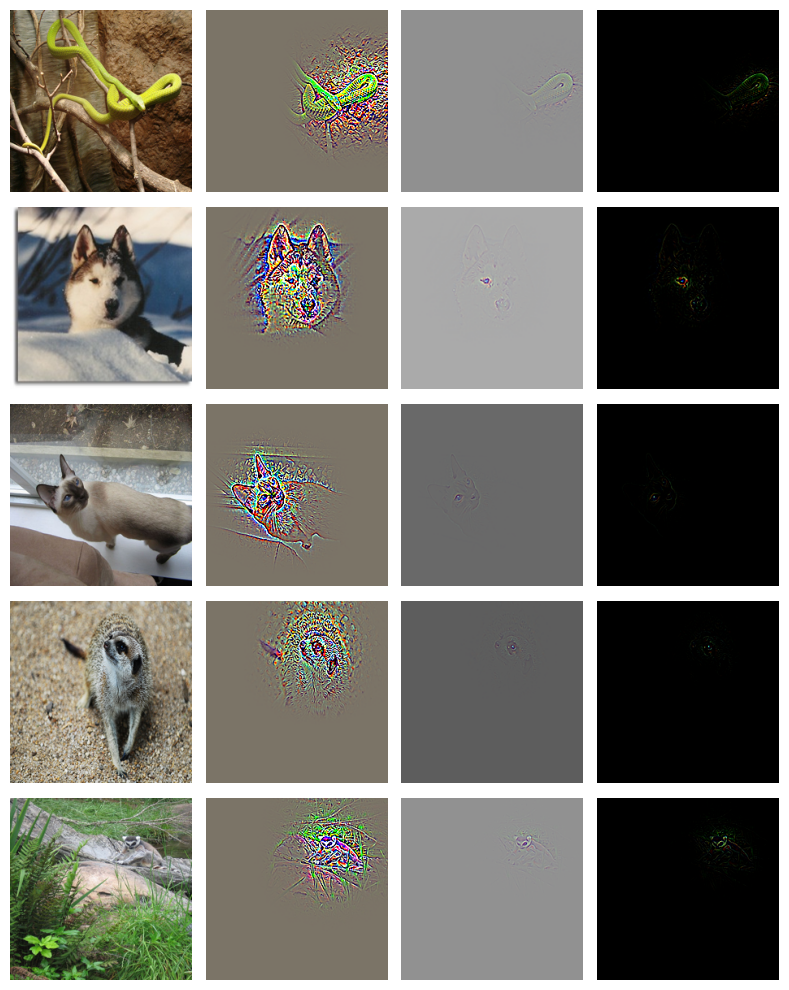

In [6]:
pil_vis = [pil_imgs, gb_out_imagenet, gb_out_maxmin, gb_out_max]
nr, nc  = len(pil_imgs), len(pil_vis)

fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(2*nc, 2*nr), tight_layout=True)

for c, vis_imgs in enumerate(pil_vis):
    for r, vis_img in enumerate(vis_imgs):
        axs[r][c].imshow(vis_img)
        axs[r][c].axis('off')

plt.show()